# Heart Attack Possibility

Christopher Mayorga | September 20, 2021

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas.plotting import register_matplotlib_converters
from scipy import stats

from acquire import get_df, get_info
from prepare import clean_heart_data, split_data, get_numeric_X_cols, min_max_scale
from explore import explore_univariate
import model as mo

#visualize
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.ion()
# tweak the matplotlib style defaults
plt.rc("figure", figsize=(13, 7))
plt.rc("font", size=14)
plt.style.use("ggplot")

#train test split from sklearn
from sklearn.model_selection import train_test_split
#imputer from sklearn
from sklearn.impute import SimpleImputer

# to evaluate performance using rmse
from sklearn.metrics import mean_squared_log_error
from math import sqrt

# for tsa
import statsmodels.api as sm

# holt's linear trend model.
from statsmodels.tsa.api import Holt

# Decision Tree
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# Logistic Regression
from sklearn.linear_model import LogisticRegression

## Acquire the Data

In [2]:
# Bring in the heart.csv data from acquire.py
df = get_df()

In [3]:
# Information Breakdown for Data
print(get_info(df))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB
None

------------------------

This dataframe has 303 rows and 14 columns.

------------------------

Null count in dataframe:
------------------------
age         0
sex         0
cp          0
trestbps    0
chol      

Attribute Information
1) age
2) sex
3) chest pain type (4 values)
4) resting blood pressure
5) serum cholestoral in mg/dl
6) fasting blood sugar > 120 mg/dl
7) resting electrocardiographic results (values 0,1,2)
8) maximum heart rate achieved
9) exercise induced angina
10) oldpeak = ST depression induced by exercise relative to rest
11) the slope of the peak exercise ST segment
12) number of major vessels (0-3) colored by flourosopy
13) thal: 0 = normal; 1 = fixed defect; 2 = reversable defect
14) target: 0= less chance of heart attack 1= more chance of heart attack

Dataset is taken for learning purpose. Source of the data : https://archive.ics.uci.edu/ml/datasets/Heart+Disease

## Prepare/Clean Data

In [4]:
# take a peek at the data
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
# Check for any duplicate rows
df.duplicated().sum()

1

In [6]:
# Use my prepare function to clean the data
df = clean_heart_data(df)

In [7]:
# See new dataframe
df.head()

,age,is_male,chest_pain,resting_blood_pressure,cholesterol,fasting_blood_sugar,restecg,max_heart_rate,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [8]:
# See new shape
df.shape

(302, 14)

**Steps taken in Prepare:**
- Re-named columns
- Dropped duplicate row

## Exploring the Data

### Visualizing

In [9]:
df.columns.to_list()

['age',
 'is_male',
 'chest_pain',
 'resting_blood_pressure',
 'cholesterol',
 'fasting_blood_sugar',
 'restecg',
 'max_heart_rate',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal',
 'target']

In [10]:
cat_vars = ['is_male', 'chest_pain', 'fasting_blood_sugar', 'restecg', 'slope', 'exang', 'thal']
quant_vars = ['age', 'resting_blood_pressure', 'cholesterol', 'oldpeak', 'ca']

### Key question: What do the distributions look like for each variable?

Bar Plot of is_male


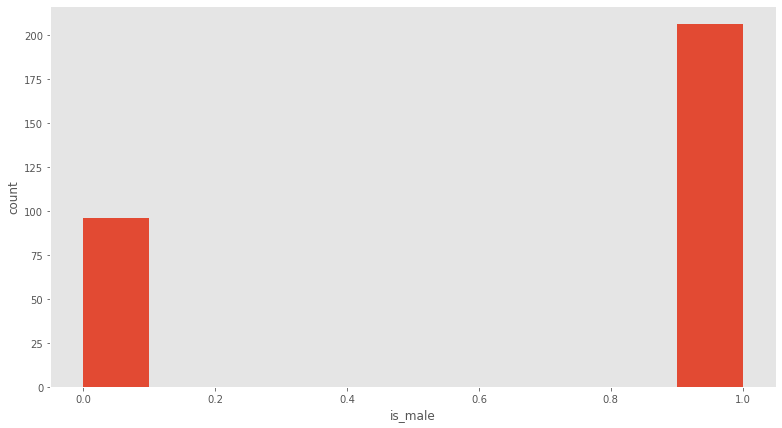

Bar Plot of chest_pain


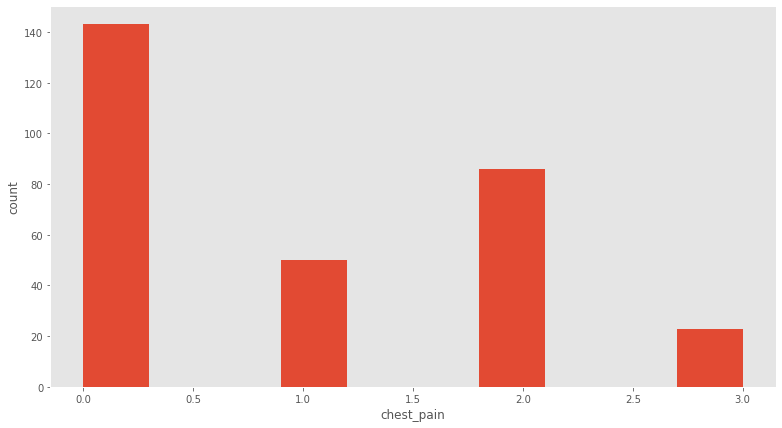

Bar Plot of fasting_blood_sugar


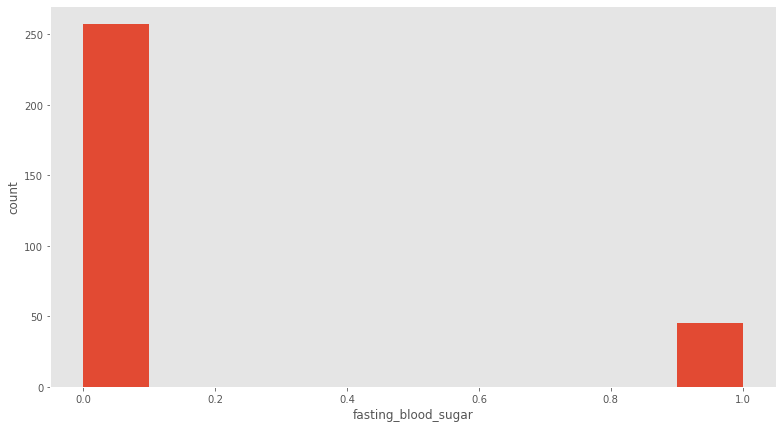

Bar Plot of restecg


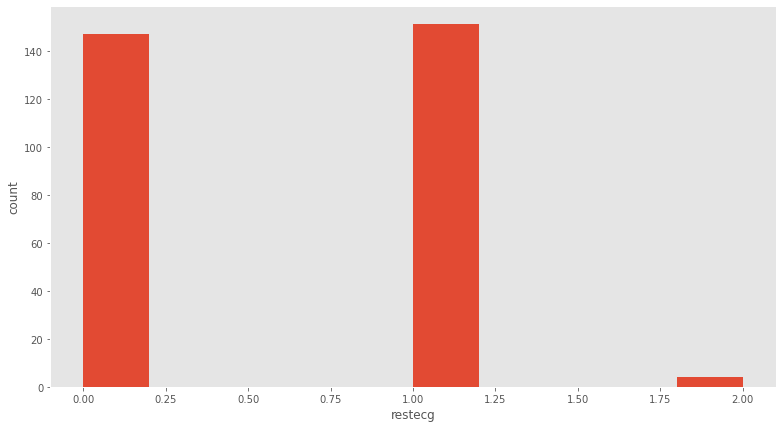

Bar Plot of slope


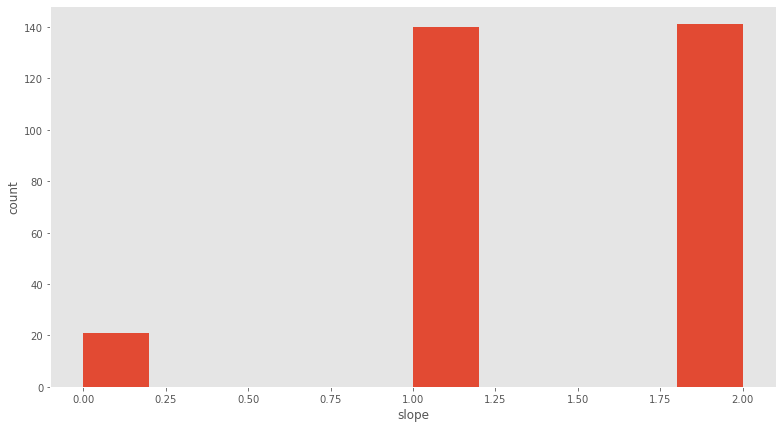

Bar Plot of exang


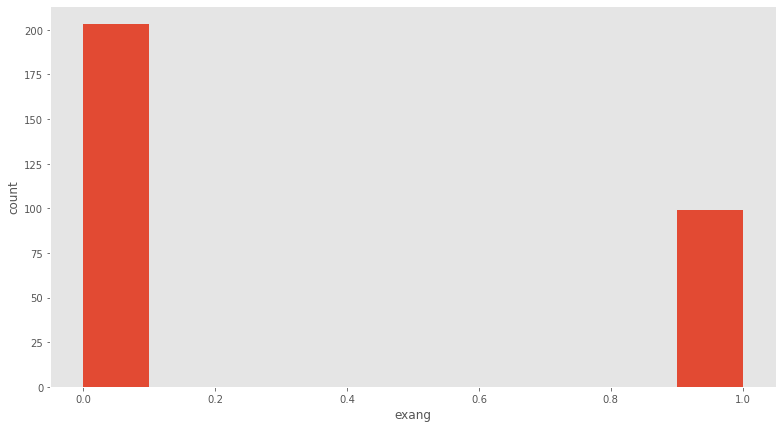

Bar Plot of thal


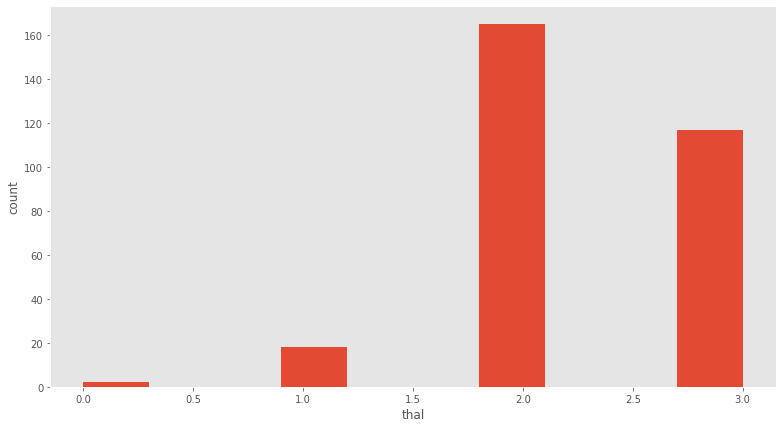

Distribution of age


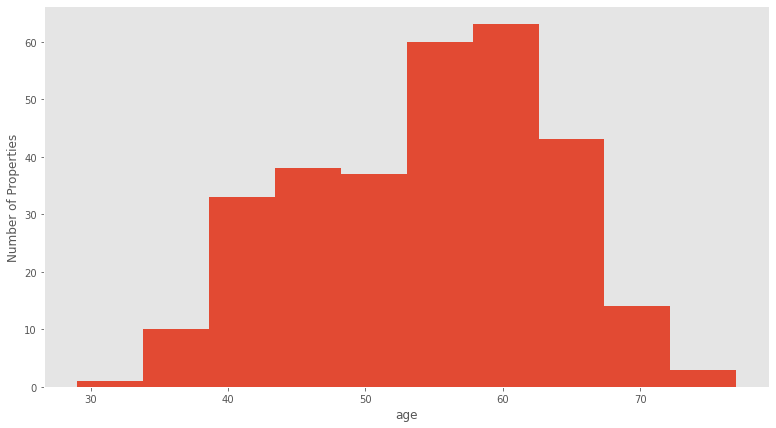

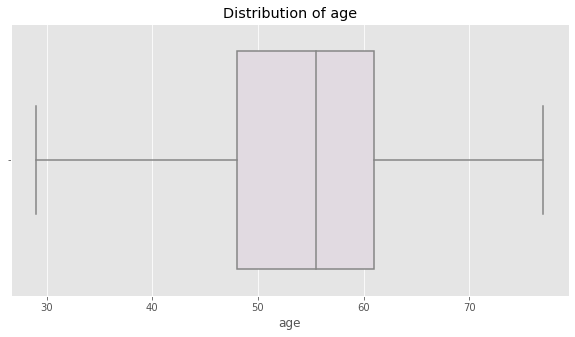

Distribution of resting_blood_pressure


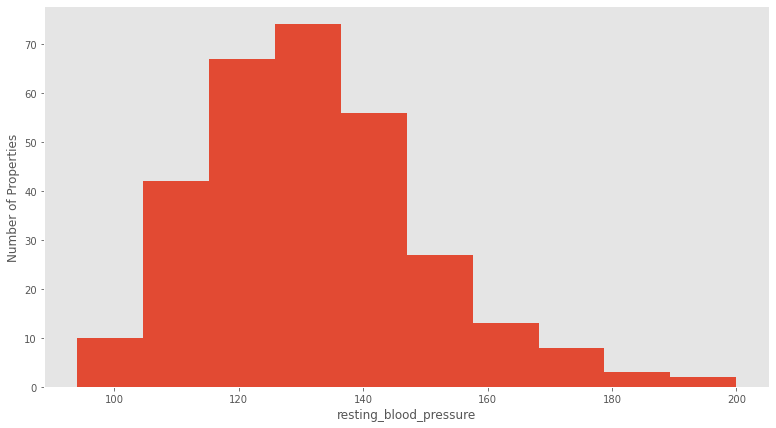

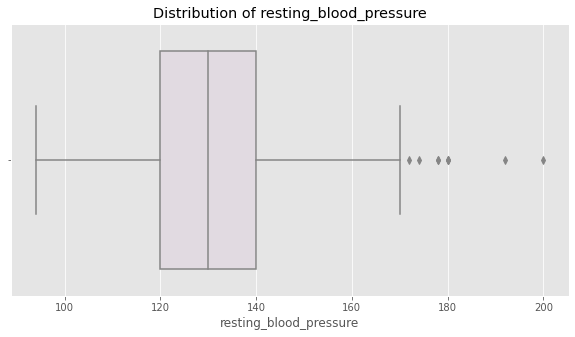

Distribution of cholesterol


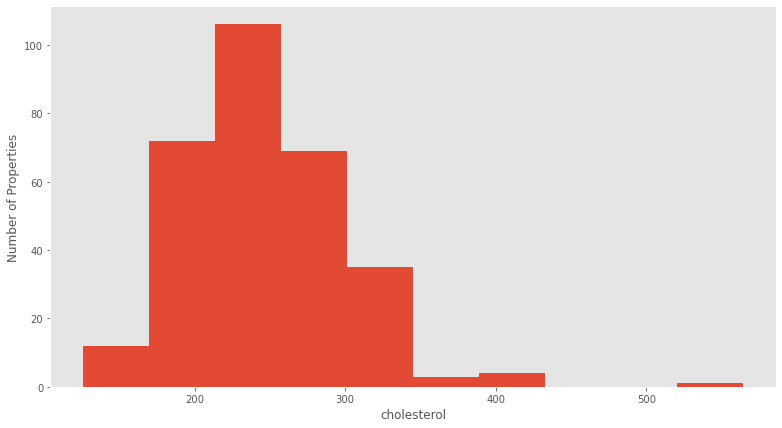

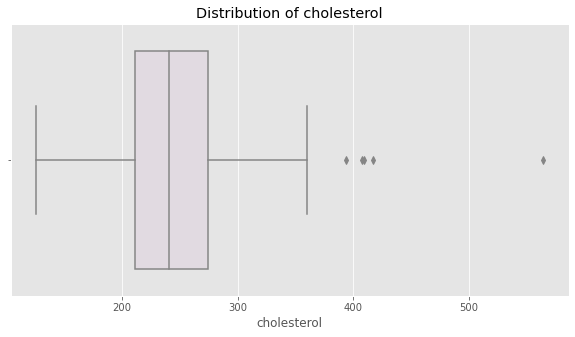

Distribution of oldpeak


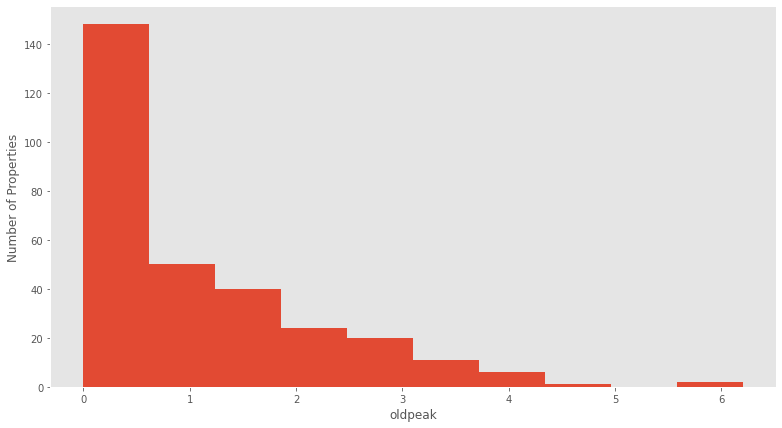

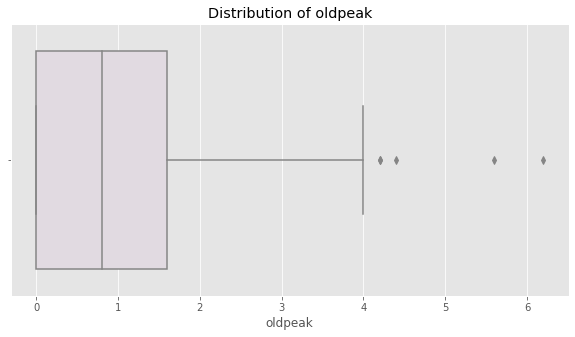

Distribution of ca


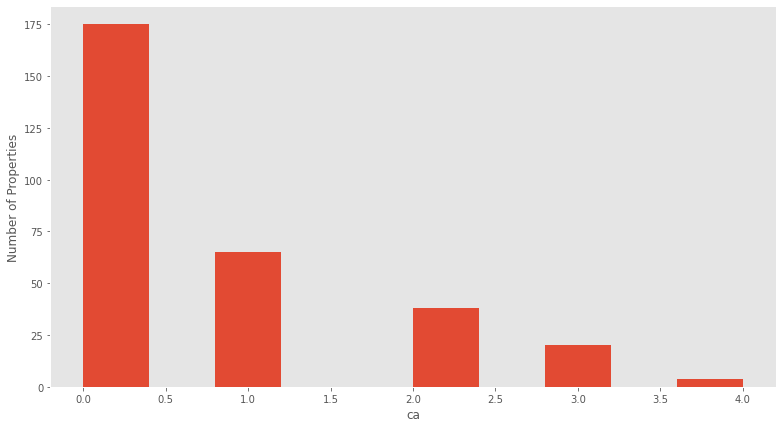

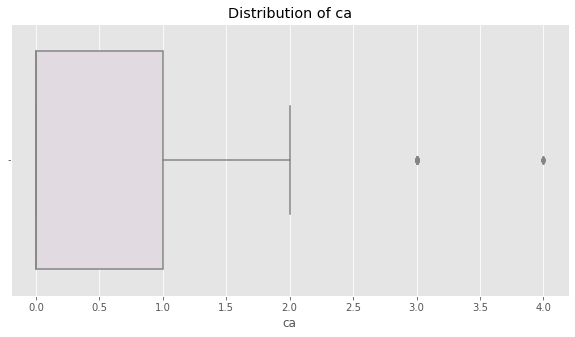

In [11]:
explore_univariate(df, cat_vars, quant_vars)

Takeaways from looking at distributions:

### Splitting Data

In [12]:
# Split data into train, validate, test
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = split_data(df, 'target')

Making Sure Our Shapes Look Good
Train: (168, 14), Validate: (73, 14), Test: (61, 14)
Making Sure We Have Positive Cases In Each Split

Train Target Value Counts:
1    91
0    77
Name: target, dtype: int64
----------------------------

Validate Target Value Counts:
1    40
0    33
Name: target, dtype: int64
----------------------------

Test Target Value Counts:
1    33
0    28
Name: target, dtype: int64
----------------------------



ValueError: not enough values to unpack (expected 9, got 3)

### Key question: How many patients are in each category for categorical variables?

In [ ]:
# For loop to see value counts of each categorical variable
print(f"Categorical variables in our dataset: {cat_vars}")
for col in cat_vars:
    print(f'Amount of Patients per {col.title()}')
    df[col].value_counts().plot.bar()
    plt.ylabel(f'{col.upper()} Frequency')
    plt.xticks(rotation=0)
    plt.xlabel(f"{col} category")
    plt.show()

In [ ]:
for col in quant_vars:
    print(f"Does {col} indicate whether or not someone has a higher likelihood of having a heart attack?")
    sns.barplot(x = 'target', y = col, data = train)
    plt.xlabel("Likelihood of having a heart attack")
    plt.show()

In [ ]:
## Universally our alpha value for all testing 

a = 0.05

In [ ]:
for col in cat_vars:
    ctab = pd.crosstab(train[col], train.target)
    print(f"Does {col} have a relationship with whether someone will have a heart attack?")
    sns.heatmap(data=ctab, annot=True, cmap='YlGnBu')
    plt.xlabel("Likelihood of having a heart attack")
    plt.show()
    chi2, p, degf, expected = stats.chi2_contingency(ctab)
    if p < a:
        print(f"Reject null hypothesis, heart attack and {col} type are not independent")
    else:
        print(f"Fail to reject null hypothesis, heart attack and {col} are independent")
    print("----------------------------------------------------------------------------")

In [ ]:
plt.figure(figsize=(12,10))
corr_matrix = train.corr()
sns.heatmap(corr_matrix, cmap='twilight_shifted', annot=True, linewidth=0.5, mask= np.triu(corr_matrix))
plt.title("Exploring Correlations with All Features and Target Variable")
plt.show()

In [ ]:
## making a heap map to look at correlations with is_fraud for the train data set
## helping me choose which features to use in my model

plt.figure(figsize = (8,5))  
sns.heatmap(train.corr()[['target']].sort_values(by='target', ascending = False), 
            cmap = 'RdBu', vmax = 1, vmin = -1, center = 0, annot = True, annot_kws={"size": 15} )
plt.title("Exploring Correlations with Target Variable Only")
plt.show()

### Statistical Tests

In [ ]:
## Universally our alpha value for all testing 

alpha = 0.05

## Modeling

In [ ]:
# Get numeric and object columns
object_cols = get_object_cols(df)
numeric_cols = get_numeric_X_cols(X_train, object_cols)

In [ ]:
# Scale columns
X_train_scaled, X_validate_scaled, X_test_scaled = min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [ ]:
mo.select_kbest(X_train_scaled, 'target', 4)

In [ ]:
rfe(X_train_scaled, 'target', 4)

## Delivery

## Conlcusions